In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
import timm
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import time
import cv2
import torch.nn.functional as F
import torchvision.utils
import torchvision
from sklearn.model_selection import train_test_split
import torch.utils.data as utils
from sklearn.model_selection import StratifiedShuffleSplit
import imgaug.augmenters as iaa

In [4]:
def imshow(img, text=None, should_save=False):
    image = img.numpy()
    plt.axis("off")
    if text:
        plt.text(
            75,
            8,
            text,
            style="italic",
            fontweight="bold",
            bbox={"facecolor": "white", "alpha": 0.8, "pad": 10},
        )
    plt.imshow(np.transpose(image , (1, 2, 0)))
    plt.show()


def show_plot(iteration, loss):
    plt.plot(iteration, loss)
    plt.show()

# **DATASET PREPERATION**

In [ ]:
class SiameseCEDARDataset(Dataset):
    def __init__(self, genuine_dir=None, forged_dir=None, transform=None):
        self.genuine_dir = genuine_dir
        self.forged_dir = forged_dir
        self.transform = transform

        self.genuine_images = {}
        self.forged_images = {}

        self._load_images_from_directory(self.genuine_dir, self.genuine_images)
        self._load_images_from_directory(self.forged_dir, self.forged_images)

        self.pairs, self.labels = self.create_pairs()

    def _load_images_from_directory(self, dir_path, image_dict):
        for root, _, files in os.walk(dir_path):
            for file in files:
                if file.endswith('.png'):
                    person_id = os.path.basename(file).split('_')[1]
                    if person_id not in image_dict:
                        image_dict[person_id] = []
                    image_dict[person_id].append(os.path.join(root, file))

    def create_pairs(self):
        pairs = []
        labels = []

        # Create positive pairs (genuine-genuine)
        for person_id, images in self.genuine_images.items():
            for i in range(len(images)):
                for j in range(i + 1, len(images)):
                    pairs.append((images[i], images[j]))
                    labels.append(1)

        # Create negative pairs (genuine-forged)
        for person_id, genuine_images in self.genuine_images.items():
            if person_id in self.forged_images:
                forged_images = self.forged_images[person_id]
                for genuine_image in genuine_images:
                    for forged_image in forged_images:
                        pairs.append((genuine_image, forged_image))
                        labels.append(0)

        return pairs, labels

    def __getitem__(self, index):
        image1_path, image2_path = self.pairs[index]

        img0 = Image.open(image1_path).convert("L")
        img1 = Image.open(image2_path).convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1, torch.tensor(self.labels[index], dtype=torch.float32)

    def __len__(self):
        return len(self.pairs)

In [3]:
original_dir = "/kaggle/input/cedardataset/signatures/full_org"
forged_dir = "/kaggle/input/cedardataset/signatures/full_forg"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
dataset = SiameseCEDARDataset(genuine_dir=original_dir, forged_dir=forged_dir, transform=transform)

In [ ]:
train_indices, testing_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)


train_dataset = utils.Subset(dataset, train_indices)
testing_dataset = utils.Subset(dataset, testing_indices)
val_indices, test_indices = train_test_split(range(len(testing_dataset)), test_size=0.5, random_state=42)
val_dataset = utils.Subset(testing_dataset, val_indices)
test_dataset = utils.Subset(testing_dataset, test_indices)



train_loader = DataLoader(train_dataset, shuffle=True, batch_size=32, num_workers=0)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=32, num_workers=0)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=32, num_workers=0)

print(len(dataset))
print(len(train_dataset))
print(len(test_dataset))
print(len(val_dataset))

In [ ]:
def count_positive_pairs(subset):
    positive_count = 0
    for _, _, label in DataLoader(subset, batch_size=1, shuffle=False):
        if label.item() == 1:
            positive_count += 1
    return positive_count

# Count positive pairs in each subset
train_positive_count = count_positive_pairs(train_dataset)
val_positive_count = count_positive_pairs(val_dataset)
test_positive_count = count_positive_pairs(test_dataset)

# Print the results
print(f"Number of positive pairs in training set: {train_positive_count}")
print(f"Number of positive pairs in validation set: {val_positive_count}")
print(f"Number of positive pairs in test set: {test_positive_count}")

# Print the total number of pairs in each subset for reference
print(f"Total number of pairs in training set: {len(train_dataset)}")
print(f"Total number of pairs in validation set: {len(val_dataset)}")
print(f"Total number of pairs in test set: {len(test_dataset)}")

# **DEFINING THE MODEL**

In [19]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

In [20]:
model = timm.create_model("xception", pretrained=True)

# Modify the first convolutional layer to accept single-channel input
original_conv = model.conv1
model.conv1 = nn.Conv2d(
    in_channels=1,  # Change to 1 for single-channel input
    out_channels=original_conv.out_channels,
    kernel_size=original_conv.kernel_size,
    stride=original_conv.stride,
    padding=original_conv.padding,
    bias=original_conv.bias
)

# If you want to initialize the new single-channel weights using the mean of the RGB weights
with torch.no_grad():
    model.conv1.weight[:, 0, :, :] = original_conv.weight.mean(dim=1)

# Check the number of input features to the final fully connected layer
in_features = model.fc.in_features

# Replace the final fully connected layer with a new one for binary classification
model.fc = nn.Linear(in_features, 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = ContrastiveLoss(margin=1.0).to(device)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)

/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


Xception(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU(inplace=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Conv

# **TRAINING THE MODEL**

In [ ]:
epochs = 10

In [ ]:
def train():
    loss=[]
    train_accuracy = []
    counter=[]
    iteration_number = 0
    for epoch in range(epochs):
        correct = 0
        total = 0
        for i, data in enumerate(train_loader,0):
            img0, img1, label = data
            img0, img1, label = img0.to(device), img1.to(device), label.to(device)
            optimizer.zero_grad()
            output1 = model(img0)
            output2 = model(img1)
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()
        print("Epoch {}\nCurrent loss: {:.6f}\n".format(epoch+1, loss_contrastive.item()))
        
        iteration_number += 10
        counter.append(iteration_number)
        loss.append(loss_contrastive.item())
    show_plot(counter, loss)
    return model

model = train()

In [ ]:
torch.save(model.state_dict(), 'siamesemodel2.pth')
print("Trained model saved to 'siamesemodel2.pth'")

In [21]:
model_state_dict = torch.load('/kaggle/input/siamesemodel2/pytorch/model1/1/siamesemodel2.pth')
model.load_state_dict(model_state_dict)

<All keys matched successfully>

# **TESTING**

In [ ]:
def test(model, test_loader, threshold):
    model.eval()
    correct = 0
    total = 0
    
    data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

    with torch.no_grad():
        for i, data in enumerate(data_loader, 0):
            img0, img1, label = data
            img0, img1, label = img0.to(device), img1.to(device), label.to(device)
            output1 = model.forward_features(img0)
            output2 = model.forward_features(img1)
            
            # Compute the Euclidean distance between output1 and output2
            distance = F.pairwise_distance(output1, output2)
            mean_distance = distance.mean().item()  # Take the mean distance
            # Apply threshold to get predictions
            predicted = (mean_distance <= threshold)
            
            correct += (predicted == label).sum().item()
            total += label.size(0)
    
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')
    return accuracy

In [ ]:
accuracy = test(model, test_dataset, threshold = 0.01)

# **NOW FINE TUNING OF THE MODEL TO ADAPT TO REAL LIFE SITUATIONS**

In [37]:
def crop_signature(image_path):
    # Read the image
    image = cv2.imread(image_path)

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply binary thresholding
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Ensure contours were found
    if contours:
        # Find the bounding box of the entire contours
        x, y, w, h = cv2.boundingRect(contours[0])  # Use the largest contour

        for contour in contours:
            # Get bounding box of current contour
            curr_x, curr_y, curr_w, curr_h = cv2.boundingRect(contour)
            
            # Update bounding box to tightly fit around contour
            x = min(x, curr_x)
            y = min(y, curr_y)
            w = max(w, curr_x + curr_w)
            h = max(h, curr_y + curr_h)

        # Crop the image to the bounding box of the signature
        cropped_image = image[y:h, x:w]

        # Save the cropped image

        return cropped_image
    else:
        # If no contours are found, save the original image
        cv2.imwrite(output_path, image)
        return image

In [38]:
cropped_image = crop_signature("/kaggle/input/mysigndataset/original_rakshit.jpg")

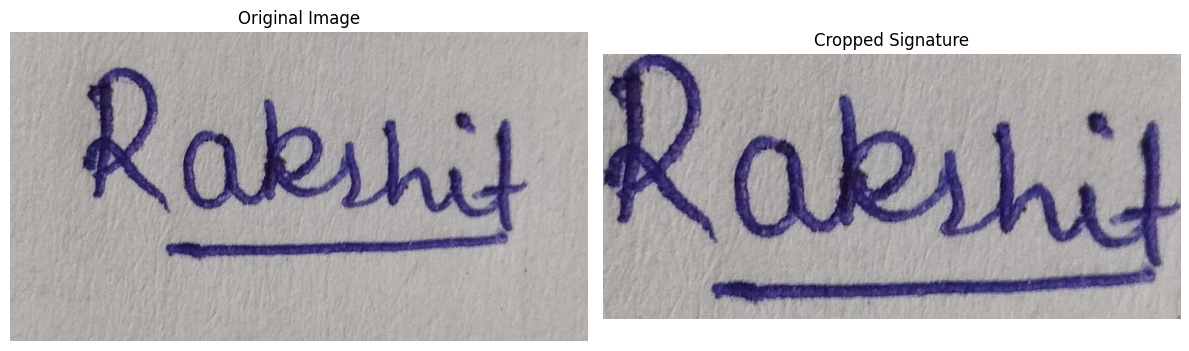

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(cv2.cvtColor(cv2.imread("/kaggle/input/mysigndataset/original_rakshit.jpg"), cv2.COLOR_BGR2RGB))
ax[0].set_title('Original Image')
ax[0].axis('off')

# Display cropped image
ax[1].imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
ax[1].set_title('Cropped Signature')
ax[1].axis('off')

plt.tight_layout()
plt.show()

In [11]:
def augment_signature(image):
    # Define the augmentations
    seq = iaa.Sequential([
        iaa.AdditiveGaussianNoise(scale=(0, 0.5*255)), 
        iaa.ElasticTransformation(alpha=(5.0, 10.0), sigma=10.0),
    ])

    augmented_images = seq(images=[image] * 100) 

    return augmented_images

In [12]:
augmented_images = augment_signature(cropped_image)

In [24]:
class FineTuneDataset(Dataset):
    
    def __init__(self, original_image, augmented_images, transform):
        self.original_image = original_image
        self.augmented_images = augmented_images
        self.transform = transform
        self.pairs, self.labels = self.create_pairs()
        
    def create_pairs(self):
        pairs = []
        labels = []
        for i in range(len(self.augmented_images)):
            pairs.append((self.original_image,self.augmented_images[i]))
            labels.append(1)
        for i in range(len(self.augmented_images)):
            for j in range(i+1, len(self.augmented_images)):
                pairs.append((self.augmented_images[i], self.augmented_images[j]))
                labels.append(1)
        return pairs, labels
    
    def __getitem__(self, index):
        image1, image2 = self.pairs[index]
        if isinstance(image1, np.ndarray):
            image1 = Image.fromarray(image1)
        if isinstance(image2, np.ndarray):
            image2 = Image.fromarray(image2)

        img0 = image1.convert("L")
        img1 = image2.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1, torch.tensor(self.labels[index], dtype=torch.float32)

    def __len__(self):
        return len(self.pairs)
        

In [25]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [26]:
fineDataset = FineTuneDataset(original_image=cropped_image, augmented_images=augmented_images, transform=transform)

In [27]:
fine_loader = DataLoader(fineDataset, shuffle=True, batch_size=32, num_workers=0)

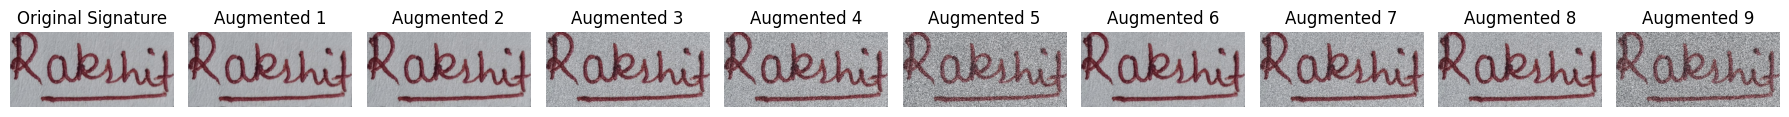

In [28]:
fig, ax = plt.subplots(1, 10, figsize=(18, 6))

ax[0].imshow(cropped_image, cmap='gray')
ax[0].set_title('Original Signature')
ax[0].axis('off')


for i in range(9):
    ax[i+1].imshow(augmented_images[i], cmap='gray')
    ax[i+1].set_title(f'Augmented {i+1}')
    ax[i+1].axis('off')

plt.tight_layout()
plt.show()

In [29]:
epochs = 10

In [30]:
def fine_tune():
    loss=[]
    train_accuracy = []
    counter=[]
    iteration_number = 0
    for epoch in range(epochs):
        correct = 0
        total = 0
        for i, data in enumerate(fine_loader,0):
            img0, img1, label = data
            img0, img1, label = img0.to(device), img1.to(device), label.to(device)
            optimizer.zero_grad()
            output1 = model(img0)
            output2 = model(img1)
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()
        print("Epoch {}\nCurrent loss: {:.6f}\n".format(epoch+1, loss_contrastive.item()))
        
        iteration_number += 10
        counter.append(iteration_number)
        loss.append(loss_contrastive.item())
    show_plot(counter, loss)
    return model

model = fine_tune()

Epoch 1
Current loss: 0.000000

Epoch 2
Current loss: 0.019314

Epoch 3
Current loss: 0.000000

Epoch 4
Current loss: 0.000000



KeyboardInterrupt: 

In [55]:
torch.save(model.state_dict(), 'siamesemodelfine2.pth')
print("Trained model saved to 'siamesemodelfine2.pth'")

Trained model saved to 'siamesemodelfine2.pth'


# **COMPARING THE IMAGES**

In [49]:
def compare_images(image_path1, image_path2):
    img1 = crop_signature(image_path1)
    img2 = crop_signature(image_path2)
    
    if isinstance(img1, np.ndarray):
        img1 = Image.fromarray(img1)
    if isinstance(img2, np.ndarray):
        img2 = Image.fromarray(img2)
    
    img1 = img1.convert("L")
    img2 = img2.convert("L")

    img1_tensor = transform(img1).unsqueeze(0).to(device)
    img2_tensor = transform(img2).unsqueeze(0).to(device)
    img1_transformed = transforms.ToPILImage()(img1_tensor.squeeze().cpu())
    img2_transformed = transforms.ToPILImage()(img2_tensor.squeeze().cpu())

    model.eval()
    with torch.no_grad():
        features1 = model.forward_features(img1_tensor)
        features2 = model.forward_features(img2_tensor)

    #similarity = nn.functional.cosine_similarity(features1, features2).mean().item()
    euclidean_distance = nn.functional.pairwise_distance(features1, features2).mean().item()

    threshold = 0.01
    print(euclidean_distance)
    if euclidean_distance < threshold:
        result1 = "The signatures are similar, possibly both original."
    else:
        result1 = "The signatures are different, one might be forged."
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img1_transformed, cmap="gray")
    axes[0].set_title("Signature 1")
    axes[0].axis("off")
    axes[1].imshow(img2_transformed, cmap="gray")
    axes[1].set_title("Signature 2")
    axes[1].axis("off")
    plt.show()

    return result1

2.6457514650246594e-06


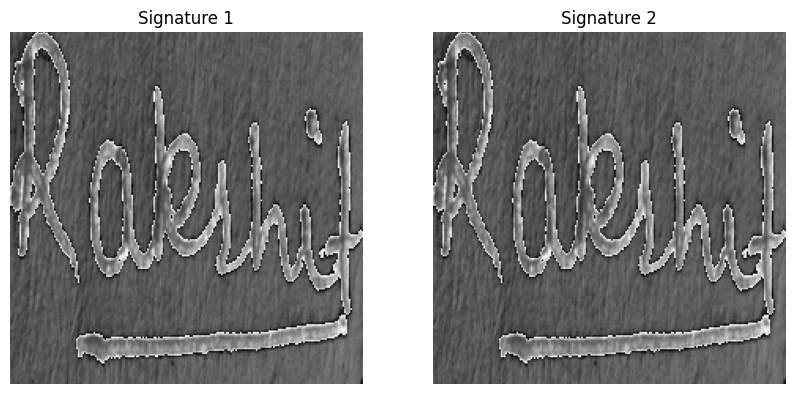

Result: The signatures are similar, possibly both original.
Time taken for comparison: 0.2867 seconds


In [54]:
image_path1 = "/kaggle/input/mysigndataset/original_rakshit.jpg"
image_path2 = "/kaggle/input/mysigndataset/original_rakshit.jpg"

start_time = time.time()
result = compare_images(image_path1, image_path2)
end_time = time.time()

time_taken = end_time - start_time
print(f'Result: {result}')
print(f'Time taken for comparison: {time_taken:.4f} seconds')